In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


dataset/2.csv
dataset/1.csv
dataset/0.csv
dataset/3.csv


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from mne.filter import filter_data


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Four classes of motion were written from MYO armband with the help of our app https://github.com/cyber-punk-me/nukleos.
# The MYO armband has 8 sensors placed on skin surface, each measures electrical activity produced by muscles beneath.

# Each dataset line has 8 consecutive readings of all 8 sensors. so 64 columns of EMG data. 
# The last column is a resulting gesture that was made while recording the data (classes 0-3)
# So each line has the following structure:
# [8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][GESTURE_CLASS]
# Data was recorded at 200 Hz, which means that each line is 8*(1/200) seconds = 40ms of record time.

# A classifier given 64 numbers would predict a gesture class (0-3).
# Gesture classes were : rock - 0, scissors - 1, paper - 2, ok - 3. 
# Rock, paper, scissors gestures are like in the game with the same name, and OK sign is index finger touching the thumb and the rest of the fingers spread. 
# Each gesture was recorded 6 times for 20 seconds. Each time recording started with the gesture being already prepared and held. 
# Recording stopped while the gesture was still being held. In total there is 120 seconds of each gesture being held in fixed position. 
# All of them recorded from the same right forearm in a short timespan. 
# Every recording of a certain gesture class was concatenated into a .csv file with a corresponding name (0-3).

df0 = pd.read_csv("dataset/0.csv", header=None)
print("Class 0 Shape", df0.shape)
df1 = pd.read_csv("dataset/1.csv", header=None)
print("Class 1 Shape", df1.shape)
df2 = pd.read_csv("dataset/2.csv", header=None)
print("Class 2 Shape", df2.shape)
df3 = pd.read_csv("dataset/3.csv", header=None)
print("Class 3 Shape", df3.shape)

df = pd.concat([df0,df1,df2,df3])
print("Combined Shape", df.shape)
data = df.values

sc = RobustScaler()
# sc = MinMaxScaler(feature_range = (0, 1))

Class 0 Shape (2910, 65)
Class 1 Shape (2903, 65)
Class 2 Shape (2943, 65)
Class 3 Shape (2922, 65)
Combined Shape (11678, 65)


(23280, 4)


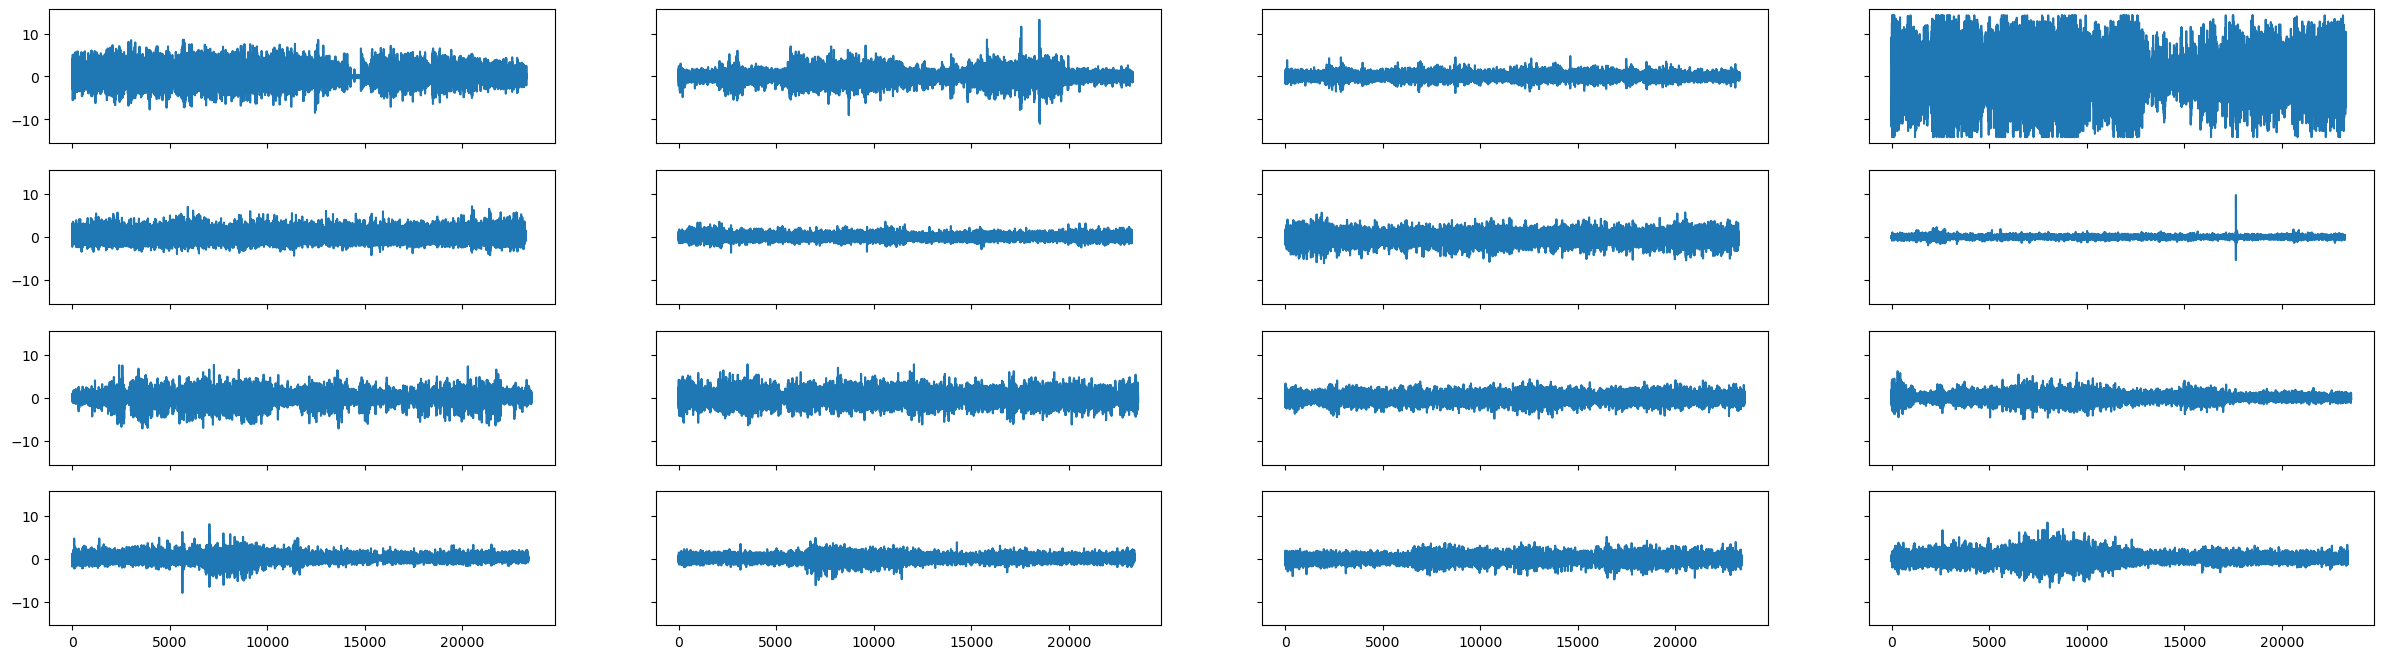

In [4]:
def plot_data(data):
    
    X0, X1, X2, X3=[],[],[],[]
    data[:,:-1] = sc.fit_transform(data[:,:-1])
    
    for i in range(data.shape[0]):
        tmp = data[i,:-1].reshape((8,8))
        # Each dataset line has 8 consecutive readings of all 8 sensors. so 64 columns of EMG data. 
        # The last column is a resulting gesture that was made while recording the data (classes 0-3) 
        # So each line has the following structure:
        # [8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][GESTURE_CLASS]
        for j in range(8):
            
            if data[i,-1] == 0:
                X0.append([tmp[j][s] for s in range(0, 8, 2)])
            
            elif data[i,-1] == 1:
                X1.append([tmp[j][s] for s in range(0, 8, 2)])
            
            elif data[i,-1] == 2:
                X2.append([tmp[j][s] for s in range(0, 8, 2)])
                # X2.append(tmp[j,:])

            elif data[i,-1] == 3:
                X3.append([tmp[j][s] for s in range(0, 8, 2)])
                # X3.append(tmp[j,:])
    
    X0, X1, X2, X3 = np.array(X0), np.array(X1), np.array(X2), np.array(X3)    
    print(X0.shape)
        
    fig, axes = plt.subplots(4,4, figsize=(30, 8), sharex=True, sharey=True)
    # for i in range(8):
    for i in range(4):
        axes[0][i].plot(X0[:,i], label='Raw Ch '+str(i))
        axes[1][i].plot(X1[:,i], label='Raw Ch '+str(i))
        axes[2][i].plot(X2[:,i], label='Raw Ch '+str(i))
        axes[3][i].plot(X3[:,i], label='Raw Ch '+str(i))
        
# vertical axis defines the EMG signal amplitude, and the horizontal axis defines the time.
# Vertical arrangement of the plots represents the 4 classes of gestures.
# Horizontal arrangement of the plots represents the (trimmed 8) 4 channels of EMG data.
plot_data(data)

In [5]:
def select_4_channels(data):
    X = []
    for i in range(data.shape[0]):
        tmp = data[i]
        for j in range(8):
            X.append([tmp[j][s] for s in range(0, 8, 2)])
    return np.array(X).reshape(-1,8,4)

def prepare_data(data, filtered=False):
    data[:,:-1] = sc.fit_transform(data[:,:-1])
    np.random.shuffle(data)
    if filtered:
        data_shape = data[:,:-1].shape
        raw_sf = 200
        bandpass_freqs = [1, 64]
        data[:,:-1] = filter_data(
            np.squeeze(data[:,:-1]).astype("float64"),
            raw_sf,
            bandpass_freqs[0],
            bandpass_freqs[1],
            verbose=0,
        )
        data[:,:-1].reshape(data_shape)
    X, y = data[:,:-1], data[:,-1]
    X = X.reshape(-1,8,8)
    X = select_4_channels(X)
    print("X prepared shape", X.shape)
    
    X_train = torch.from_numpy(X[:7700])
    y_train = torch.from_numpy(y[:7700])
    X_test = torch.from_numpy(X[7700:])
    y_test = torch.from_numpy(y[7700:])
    
    return X_train.float().to(device), y_train.long().to(device), X_test.float().to(device), y_test.long().to(device)
# def prepare_data(data):
#     data[:,:-1] = sc.fit_transform(data[:,:-1])
#     np.random.shuffle(data)
#     X, y = data[:,:-1], data[:,-1]
#     X = X.reshape(-1,8,8)
#     X = select_4_channels(X)
#     print("X prepared shape", X.shape)
    
#     X_train = torch.from_numpy(X[:7700])
#     y_train = torch.from_numpy(y[:7700])
#     X_test = torch.from_numpy(X[7700:])
#     y_test = torch.from_numpy(y[7700:])
    
#     return X_train.float().to(device), y_train.long().to(device), X_test.float().to(device), y_test.long().to(device)

In [6]:
from scipy.signal import welch
from scipy.fftpack import fft
from detecta import detect_peaks
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report

def get_values(y_values, T, N, f_s):
    y_values = y_values
    x_values = [T * kk for kk in range(0,len(y_values))]
    assert len(x_values) == len(y_values)
    return x_values, y_values

def get_fft_values(y_values, T, N, f_s):
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[:N//2])
    f_values = np.linspace(0.0, f_s/2, len(fft_values))
    return f_values, fft_values

def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]

def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values

def get_first_n_peaks(x, y, no_peaks=5):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks], y_[:no_peaks]
    else:
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks
    
def get_features(x_values, y_values, mph):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks], no_peaks=10)
    return peaks_x + peaks_y

def extract_features_labels(dataset, labels, T, N, f_s):
    percentile = 1 # was 5
    denominator = 1000
    list_of_features = []
    list_of_labels = []
    for signal_no in range(0, len(dataset)):
        features = []
        list_of_labels.append(labels[signal_no])
        for i in range(0,dataset.shape[1]):
            signal = dataset[signal_no, i, :]
            
            signal_min = np.nanpercentile(signal, percentile)
            signal_max = np.nanpercentile(signal, 100-percentile)
            mph = signal_min + (signal_max - signal_min)/denominator
            
            features += get_features(*get_psd_values(signal, T, N, f_s), mph)
            features += get_features(*get_fft_values(signal, T, N, f_s), mph)
            features += get_features(*get_autocorr_values(signal, T, N, f_s), mph)
            
        list_of_features.append(features)
    return np.array(list_of_features), np.array(list_of_labels)

/tmp/ipykernel_222511/1332487248.py:16: RuntimeWarning: filter_length (661) is longer than the signal (64), distortion is likely. Reduce filter length or filter a longer signal.
  data[:,:-1] = filter_data(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:   

X prepared shape (11678, 8, 4)
Train Data Shape  (7700, 4, 8) torch.Size([7700])
Test Data Shape  (3978, 4, 8) torch.Size([3978])


/tmp/ipykernel_222511/1598997008.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.permute(torch.tensor(data), (0, 2, 1)).numpy()
/home/madnad/anaconda3/lib/python3.12/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 8, using nperseg = 8
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


shape of features and labels
(7700, 240) (7700,)


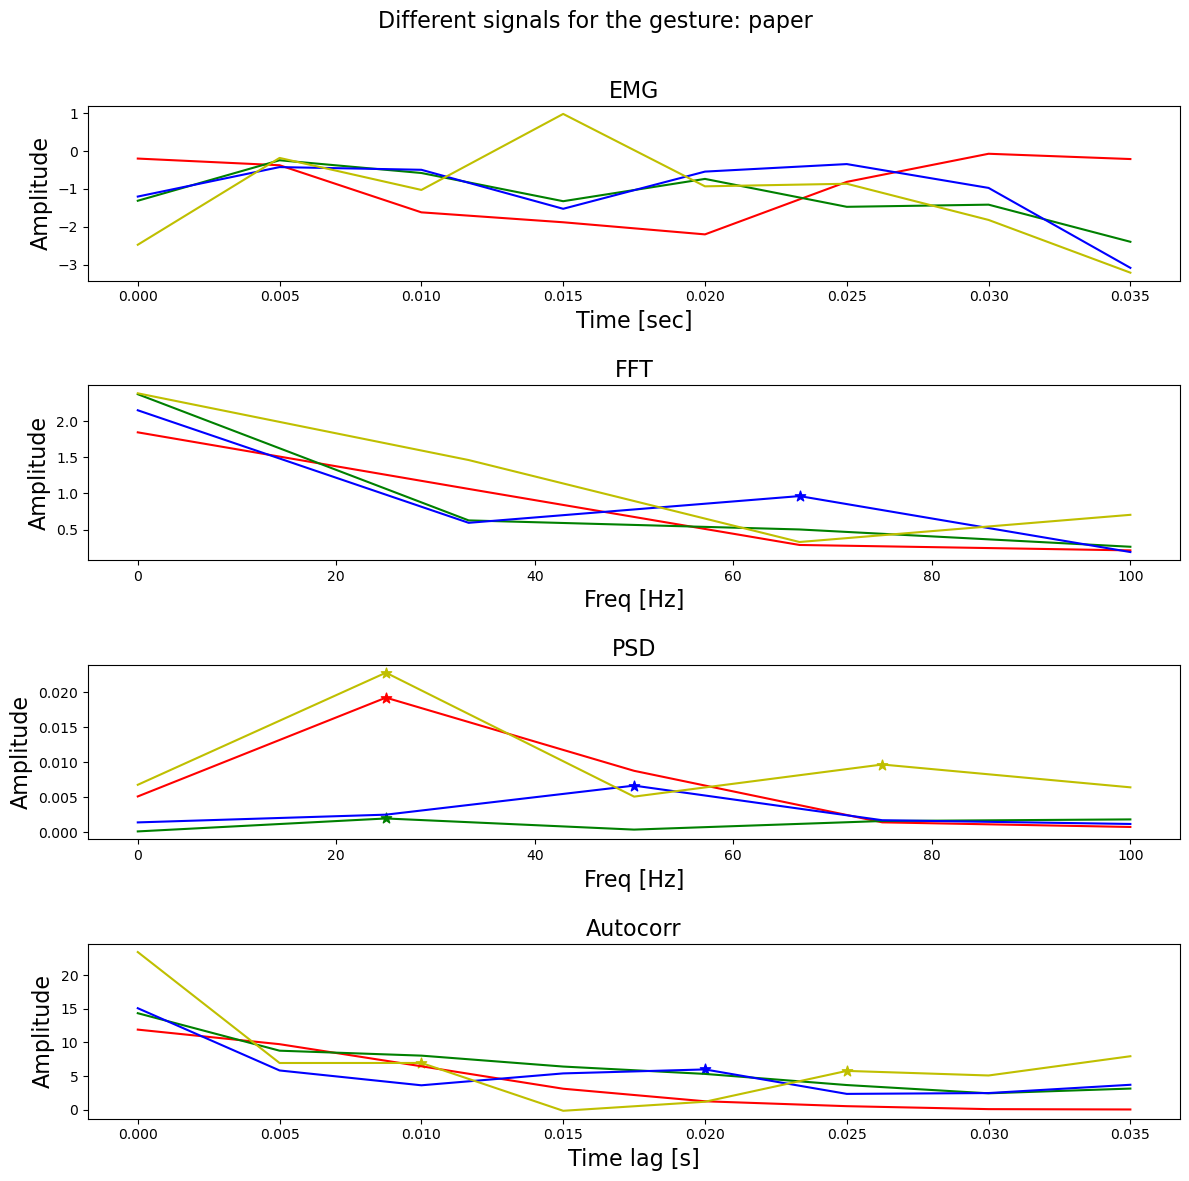

Accuracy on training set is : 1.0
Accuracy on test set is : 0.8036701860231272
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1005
           1       0.83      0.88      0.85      1008
           2       0.73      0.74      0.74       992
           3       0.74      0.71      0.73       973

    accuracy                           0.80      3978
   macro avg       0.80      0.80      0.80      3978
weighted avg       0.80      0.80      0.80      3978



In [7]:
# class EmgDataset(Dataset):
    
#     def __init__(self, X, y):
#         self.X = X
#         self.y = y
    
#     def __getitem__(self, index):
#         return self.X[index], self.y[index]
    
#     def __len__(self):
#         return self.X.shape[0]

# I have: [4sensors][4sensors][4sensors][4sensors][4sensors][4sensors][4sensors][4sensors][GESTURE_CLASS]
# my x_data is: [4sensors][4sensors][4sensors][4sensors][4sensors][4sensors][4sensors][4sensors]
# I want: [[8 measurements of sensor 1], [8 measurements of sensor 2], [8 measurements of sensor 3], [8 measurements of sensor 4]]
def separate_channels(data):
    return torch.permute(torch.tensor(data), (0, 2, 1)).numpy()

gestures_description = {0: 'rock', 1: 'scissors', 2: 'paper', 3: 'ok'}

list_functions = [get_values, get_fft_values, get_psd_values, get_autocorr_values]

# Data was recorded at 200 Hz, which means that each line is 8*(1/200) seconds = 40ms of record time.
N = 8
f_s = 200
t_n = 0.04
T = t_n / N

x_train, y_train, x_test, y_test = prepare_data(data, filtered=True)
x_train = separate_channels(x_train)
x_test = separate_channels(x_test)

print("Train Data Shape ",x_train.shape, y_train.shape)
print("Test Data Shape ",x_test.shape, y_test.shape)

y_train = y_train.numpy()
X_train, Y_train = extract_features_labels(x_train, y_train, T, N, f_s)

y_test = y_test.numpy()
X_test, Y_test = extract_features_labels(x_test, y_test, T, N, f_s)

print('shape of features and labels')
print(X_train.shape, Y_train.shape)
   

labels = ['channel 1', 'channel 2', 'channel 3', 'channel 4']
colors = ['r' , 'g', 'b', 'y']
suptitle = "Different signals for the gesture: {}"

xlabels = ['Time [sec]', 'Freq [Hz]', 'Freq [Hz]', 'Time lag [s]']
ylabel = 'Amplitude'
axtitles = [['EMG'],
            ['FFT'],
            ['PSD'],
            ['Autocorr']
           ]


signal_no = 80
signals = x_train[signal_no, :, :]
label = y_train[signal_no]
gesture_name = gestures_description[label]

f, axarr = plt.subplots(nrows=4, ncols=1, figsize=(12,12))
f.suptitle(suptitle.format(gesture_name), fontsize=16)

for row_no in range(0,4):
    for comp_no in range(0,4):
        col_no = comp_no // 4
        plot_no = comp_no % 4
        color = colors[plot_no]
        label = labels[plot_no]

        axtitle  = axtitles[row_no][col_no]
        xlabel = xlabels[row_no]
        value_retriever = list_functions[row_no]

        ax = axarr[row_no]
        ax.set_title(axtitle, fontsize=16)
        ax.set_xlabel(xlabel, fontsize=16)
        if col_no == 0:
            ax.set_ylabel(ylabel, fontsize=16)

        signal_component = signals[comp_no, :]
        x_values, y_values = value_retriever(signal_component, T, N, f_s)
        ax.plot(x_values, y_values, linestyle='-', color=color, label=label)
        if row_no > 0:
            min_peak_height = 0.1 * np.nanmax(y_values)
            indices_peaks = detect_peaks(y_values, mph=min_peak_height)
            ax.scatter(x_values[indices_peaks], y_values[indices_peaks], c=color, marker='*', s=60)
        if col_no == 2:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))            
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.6)
plt.show()

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, Y_train)
print("Accuracy on training set is : {}".format(clf.score(X_train, Y_train)))
print("Accuracy on test set is : {}".format(clf.score(X_test, Y_test)))
Y_test_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_test_pred))